# Exploratory Data Analysis (2/2)
After using the ETL pipeline to load the data into a csv file, we can now use this data to perform some exploratory data analysis. This notebook documents 
* The preprocessing of the data for analysis
* Exploratory Data Analysis on this dataset 
* Visualizations of the data

In [43]:
import os
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import chi2

from tqdm import tqdm

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

The data is loaded by chunks from the csv file into a pandas dataframe as it is a relatively large dataset

In [44]:
%%time
file_path = '../data/cleaned/taxi_data.csv'
chunksize = 10**6

with pd.read_csv(file_path, chunksize=chunksize) as reader:
    taxi_df = pd.concat([chunk for chunk in reader])

taxi_df.head()

CPU times: total: 13.3 s
Wall time: 13.4 s


,booking_id,driver_id,name,date_of_birth,gender,car_model,car_make_year,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,rating,safety_label
0,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.000,143.298,-1.706,-9.271,-1.209,-0.029,-0.033,0.015,2.000,0.228,4.000,0
1,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.000,143.298,-1.417,-9.548,-1.861,-0.022,0.005,-0.026,3.000,0.228,4.000,0
2,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.000,143.298,-0.347,-9.533,-1.205,0.015,-0.050,0.025,9.000,0.228,4.000,0
3,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.000,143.298,-0.601,-9.452,-2.158,0.005,-0.012,-0.004,11.000,0.228,4.000,0
4,0,48,Lilia,1974-08-13,Male,Mercedes-Benz,2013-01-01,8.000,143.298,-0.598,-9.863,-1.673,-0.000,0.000,-0.010,12.000,0.228,4.000,0


In [45]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   booking_id      int64  
 1   driver_id       int64  
 2   name            object 
 3   date_of_birth   object 
 4   gender          object 
 5   car_model       object 
 6   car_make_year   object 
 7   accuracy        float64
 8   bearing         float64
 9   acceleration_x  float64
 10  acceleration_y  float64
 11  acceleration_z  float64
 12  gyro_x          float64
 13  gyro_y          float64
 14  gyro_z          float64
 15  second          float64
 16  speed           float64
 17  rating          float64
 18  safety_label    int64  
dtypes: float64(11), int64(3), object(5)
memory usage: 1.1+ GB




## Analysis Setup

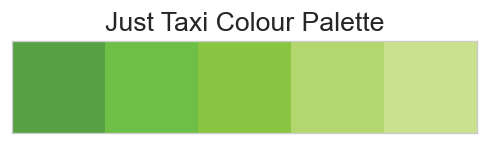

In [46]:
# set dpi to 120 for better resolution
plt.rcParams['figure.dpi'] = 120

# set style
sns.set_style('whitegrid')

# set font family
hfont = {'fontname':'Arial'}

# set colour palette for better visualisations
palette = ['#58A044', '#6DBF46', '#89C541', '#B3D66F', '#CAE18E']

sns.palplot(palette)
plt.title('Just Taxi Colour Palette', fontsize=16)
plt.grid(False)
plt.show()


## Missingness Analysis

In [47]:
rows, columns = taxi_df.shape

null_count = taxi_df.isna().sum()
null_percent = null_count / rows

nullity = pd.DataFrame({
    'null_count' :  null_count,
    'null_percent' : null_percent.apply(lambda x: x)
}, index=null_count.index).sort_values(
    by=['null_count', 'null_percent'], ascending=False)

nullity[nullity['null_count'] > 0]

num_null_rows = taxi_df.isna().any(axis=1).sum()
pct_null_rows = num_null_rows / rows

print(f'No. of rows with at least one missing value: {num_null_rows}')
print(f'Percentage of rows with at least one missing value: {round((pct_null_rows) * 100, 2)}%')

No. of rows with at least one missing value: 955920
Percentage of rows with at least one missing value: 12.8%


# Preprocessing
Initial preprocessing is done to prepare the data for Exploratory Data Analysis. This includes

* Forward fill bearing, acceleration, gyroscope, and speed values
* Impute accuracy with mean of booking_id

* Extracting driver's age using their date of birth
* Extracting the car's year of make of make from car_make_year, removing day and month
* Converting seconds to minutes for easier analysis
* Converting speed from m/s to km/h for easier analysis
* Converting compass bearing to their general directions for ease of analysis (North, North-West, East, etc.)
* Dropped driver_id, driver's date_of_birth

In [48]:
cleaned_df = taxi_df.copy()

# setting multi-index
cleaned_df = cleaned_df.set_index(['booking_id', 'second'])
cleaned_df = cleaned_df.sort_index(level=1).sort_index(level=0)

In [49]:
# get index of booking_id with missing values
missing = cleaned_df[cleaned_df.isna().any(axis=1)].index.get_level_values(0).unique()

In [50]:
%%time
# forwards fill missing values
for b_id in tqdm(missing):
    cleaned_df.loc[b_id, 'accuracy'].fillna(value=cleaned_df.loc[b_id, 'accuracy'].mean(), inplace=True)
    cleaned_df.loc[b_id, 'bearing'].ffill(inplace=True)
    cleaned_df.loc[b_id, 'acceleration_x'].ffill(inplace=True)
    cleaned_df.loc[b_id, 'acceleration_y'].ffill(inplace=True)
    cleaned_df.loc[b_id, 'acceleration_z'].ffill(inplace=True)
    cleaned_df.loc[b_id, 'gyro_x'].ffill(inplace=True)
    cleaned_df.loc[b_id, 'gyro_y'].ffill(inplace=True)
    cleaned_df.loc[b_id, 'gyro_z'].ffill(inplace=True)
    cleaned_df.loc[b_id, 'speed'].ffill(inplace=True)

100%|██████████| 20000/20000 [01:23<00:00, 238.63it/s]

CPU times: total: 1min 23s
Wall time: 1min 23s


In [51]:
%%time
# backwards fill missing values
for b_id in tqdm(missing):
    cleaned_df.loc[b_id, 'bearing'].bfill(inplace=True)
    cleaned_df.loc[b_id, 'acceleration_x'].bfill(inplace=True)
    cleaned_df.loc[b_id, 'acceleration_y'].bfill(inplace=True)
    cleaned_df.loc[b_id, 'acceleration_z'].bfill(inplace=True)
    cleaned_df.loc[b_id, 'gyro_x'].bfill(inplace=True)
    cleaned_df.loc[b_id, 'gyro_y'].bfill(inplace=True)
    cleaned_df.loc[b_id, 'gyro_z'].bfill(inplace=True)
    cleaned_df.loc[b_id, 'speed'].bfill(inplace=True)

cleaned_df = cleaned_df.reset_index()

100%|██████████| 20000/20000 [01:07<00:00, 296.87it/s]


CPU times: total: 1min 7s
Wall time: 1min 7s


In [52]:
%%time
# set date_of_birth to datetime
cleaned_df['date_of_birth'] = pd.to_datetime(cleaned_df['date_of_birth'])

# extract years from car_make_year
cleaned_df['car_make_year'] = cleaned_df['car_make_year'].apply(lambda x: int(x.split('-')[0]))

# calculate magnitude of acceleration sqrt(x^2 + y^2 + z^2)
a_x = cleaned_df['acceleration_x']
a_y = cleaned_df['acceleration_y']
a_z = cleaned_df['acceleration_z']
cleaned_df['MA (m/s^2)'] = np.sqrt(a_x**2 + a_y**2 + a_z**2)

# magnitude of angular velocity?
g_x = cleaned_df['gyro_x']
g_y = cleaned_df['gyro_y']
g_z = cleaned_df['gyro_z']
cleaned_df['MAV (rad/s)'] = np.sqrt(g_x**2 + g_y**2 + g_z**2)

# convert driver dob to age (current date - dob)
cleaned_df['driver_age'] = pd.to_datetime('today').year - cleaned_df['date_of_birth'].dt.year

# convert seconds to minutes
cleaned_df['duration (mins)'] = round(cleaned_df['second'] / 60, 2)

# convert speed (meters per second) to kilometers per hour
cleaned_df['speed (km/h)'] = cleaned_df['speed'] * 3.6

# convert bearing to categorical variable 
cleaned_df['direction'] = cleaned_df['bearing'].apply(
    lambda x: 
        'North' if x >= 337.5 or x < 22.5 else
        'North East' if x >= 22.5 and x < 67.5 else
        'East' if x >= 67.5 and x < 112.5 else
        'South East' if x >= 112.5 and x < 157.5 else
        'South' if x >= 157.5 and x < 202.5 else
        'South West' if x >= 202.5 and x < 247.5 else
        'West' if x >= 247.5 and x < 292.5 
        else 'North West'
)

# drop unnecessary columns
cols = ['driver_id', 'date_of_birth', 'bearing']
cleaned_df.drop(columns=cols, inplace=True)

# reorder columns
cleaned_df = cleaned_df[['booking_id', 'name', 'driver_age', 'gender', 'car_model', 'car_make_year', 'accuracy', 'direction', 
                         'acceleration_x', 'acceleration_y', 'acceleration_z','MA (m/s^2)', 'gyro_x', 'gyro_y', 'gyro_z', 'MAV (rad/s)', 
                        'second', 'duration (mins)', 'speed (km/h)', 'speed', 'rating', 'safety_label']]

CPU times: total: 11 s
Wall time: 11.1 s


In [53]:
cleaned_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   booking_id       7469656 non-null  int64  
 1   name             7469656 non-null  object 
 2   driver_age       7469656 non-null  int64  
 3   gender           7469656 non-null  object 
 4   car_model        7469656 non-null  object 
 5   car_make_year    7469656 non-null  int64  
 6   accuracy         7469656 non-null  float64
 7   direction        7469656 non-null  object 
 8   acceleration_x   7469656 non-null  float64
 9   acceleration_y   7469656 non-null  float64
 10  acceleration_z   7469656 non-null  float64
 11  MA (m/s^2)       7469656 non-null  float64
 12  gyro_x           7469656 non-null  float64
 13  gyro_y           7469656 non-null  float64
 14  gyro_z           7469656 non-null  float64
 15  MAV (rad/s)      7469656 non-null  float64
 16  second           7

In [54]:
cleaned_df.isna().sum()

booking_id         0
name               0
driver_age         0
gender             0
car_model          0
car_make_year      0
accuracy           0
direction          0
acceleration_x     0
acceleration_y     0
acceleration_z     0
MA (m/s^2)         0
gyro_x             0
gyro_y             0
gyro_z             0
MAV (rad/s)        0
second             0
duration (mins)    0
speed (km/h)       0
speed              0
rating             0
safety_label       0
dtype: int64

In [55]:
# export cleaned dataset if it doesn't exist
file_path = '../data/cleaned/cleaned_taxi_data.csv'
if not os.path.exists(file_path):
    cleaned_df.to_csv(file_path, index=False)

# Exploratory Data Analysis
After preprocessing, we can now perform some exploratory data analysis on the dataset

In [56]:
%%time
# dask dataframes are "lazy" and data is only loaded when it is needed for a computation
file_path = '../data/cleaned/cleaned_taxi_data.csv'
cleaned_df = dd.read_csv(file_path)
cleaned_df = cleaned_df.persist()  # persist data in memory for faster computation in subsequent cells
cleaned_df.head()

CPU times: total: 30.2 s
Wall time: 8.53 s


,booking_id,name,driver_age,gender,car_model,car_make_year,accuracy,direction,acceleration_x,acceleration_y,...,gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),speed,rating,safety_label
0,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-1.706,-9.271,...,-0.029,-0.033,0.015,0.046,2.000,0.030,0.822,0.228,4.000,0
1,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-1.417,-9.548,...,-0.022,0.005,-0.026,0.035,3.000,0.050,0.822,0.228,4.000,0
2,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-0.347,-9.533,...,0.015,-0.050,0.025,0.058,9.000,0.150,0.822,0.228,4.000,0
3,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-0.601,-9.452,...,0.005,-0.012,-0.004,0.013,11.000,0.180,0.822,0.228,4.000,0
4,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-0.598,-9.863,...,-0.000,0.000,-0.010,0.010,12.000,0.200,0.822,0.228,4.000,0


In [57]:
cleaned_df.compute().isna().sum()

booking_id         0
name               0
driver_age         0
gender             0
car_model          0
car_make_year      0
accuracy           0
direction          0
acceleration_x     0
acceleration_y     0
acceleration_z     0
MA (m/s^2)         0
gyro_x             0
gyro_y             0
gyro_z             0
MAV (rad/s)        0
second             0
duration (mins)    0
speed (km/h)       0
speed              0
rating             0
safety_label       0
dtype: int64

## Descriptive Analysis

In [58]:
cleaned_df.dtypes

booking_id           int64
name                object
driver_age           int64
gender              object
car_model           object
car_make_year        int64
accuracy           float64
direction           object
acceleration_x     float64
acceleration_y     float64
acceleration_z     float64
MA (m/s^2)         float64
gyro_x             float64
gyro_y             float64
gyro_z             float64
MAV (rad/s)        float64
second             float64
duration (mins)    float64
speed (km/h)       float64
speed              float64
rating             float64
safety_label         int64
dtype: object

In [59]:
rows, columns = cleaned_df.shape
print(f'Number of rows: {rows.compute()}')  # delayed computation
print(f'Number of columns: {columns}')

Number of rows: 7469656
Number of columns: 22


In [60]:
unique_vals = cleaned_df.nunique().compute().sort_values(ascending=False)
display(unique_vals)

MA (m/s^2)         7441528
MAV (rad/s)        7134601
speed              3139184
speed (km/h)       3138996
gyro_y             2152056
gyro_x             1979270
gyro_z             1683418
acceleration_z     1302936
acceleration_x      904124
acceleration_y      854584
accuracy             57317
booking_id           20000
second                6256
duration (mins)       6256
name                   147
driver_age              24
car_make_year           10
car_model               10
direction                8
rating                   5
gender                   2
safety_label             2
dtype: int64

## Summary Statistics

In [61]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cleaned_df.describe().compute().T

,count,mean,std,min,25%,50%,75%,max
booking_id,7469656.000,818337115843.641,495334756423.033,0.000,386547056641.000,807453851682.000,1254130450479.000,1709396983975.000
driver_age,7469656.000,39.298,6.690,27.000,34.000,41.000,45.000,50.000
car_make_year,7469656.000,2009.430,2.402,2004.000,2008.000,2011.000,2011.000,2013.000
accuracy,7469656.000,11.621,86.749,0.750,3.900,4.811,9.000,6070.101
acceleration_x,7469656.000,0.069,1.424,-38.984,-0.453,0.105,0.696,66.873
acceleration_y,7469656.000,4.468,8.130,-57.800,3.572,9.206,9.744,72.810
acceleration_z,7469656.000,0.897,3.252,-78.448,-0.745,1.049,3.062,78.056
MA (m/s^2),7469656.000,9.893,1.267,0.005,9.575,9.828,10.148,95.638
gyro_x,7469656.000,-0.002,0.145,-48.456,-0.025,-0.000,0.024,38.708
gyro_y,7469656.000,0.000,0.338,-57.345,-0.028,0.001,0.033,80.315


## Outlier Analysis

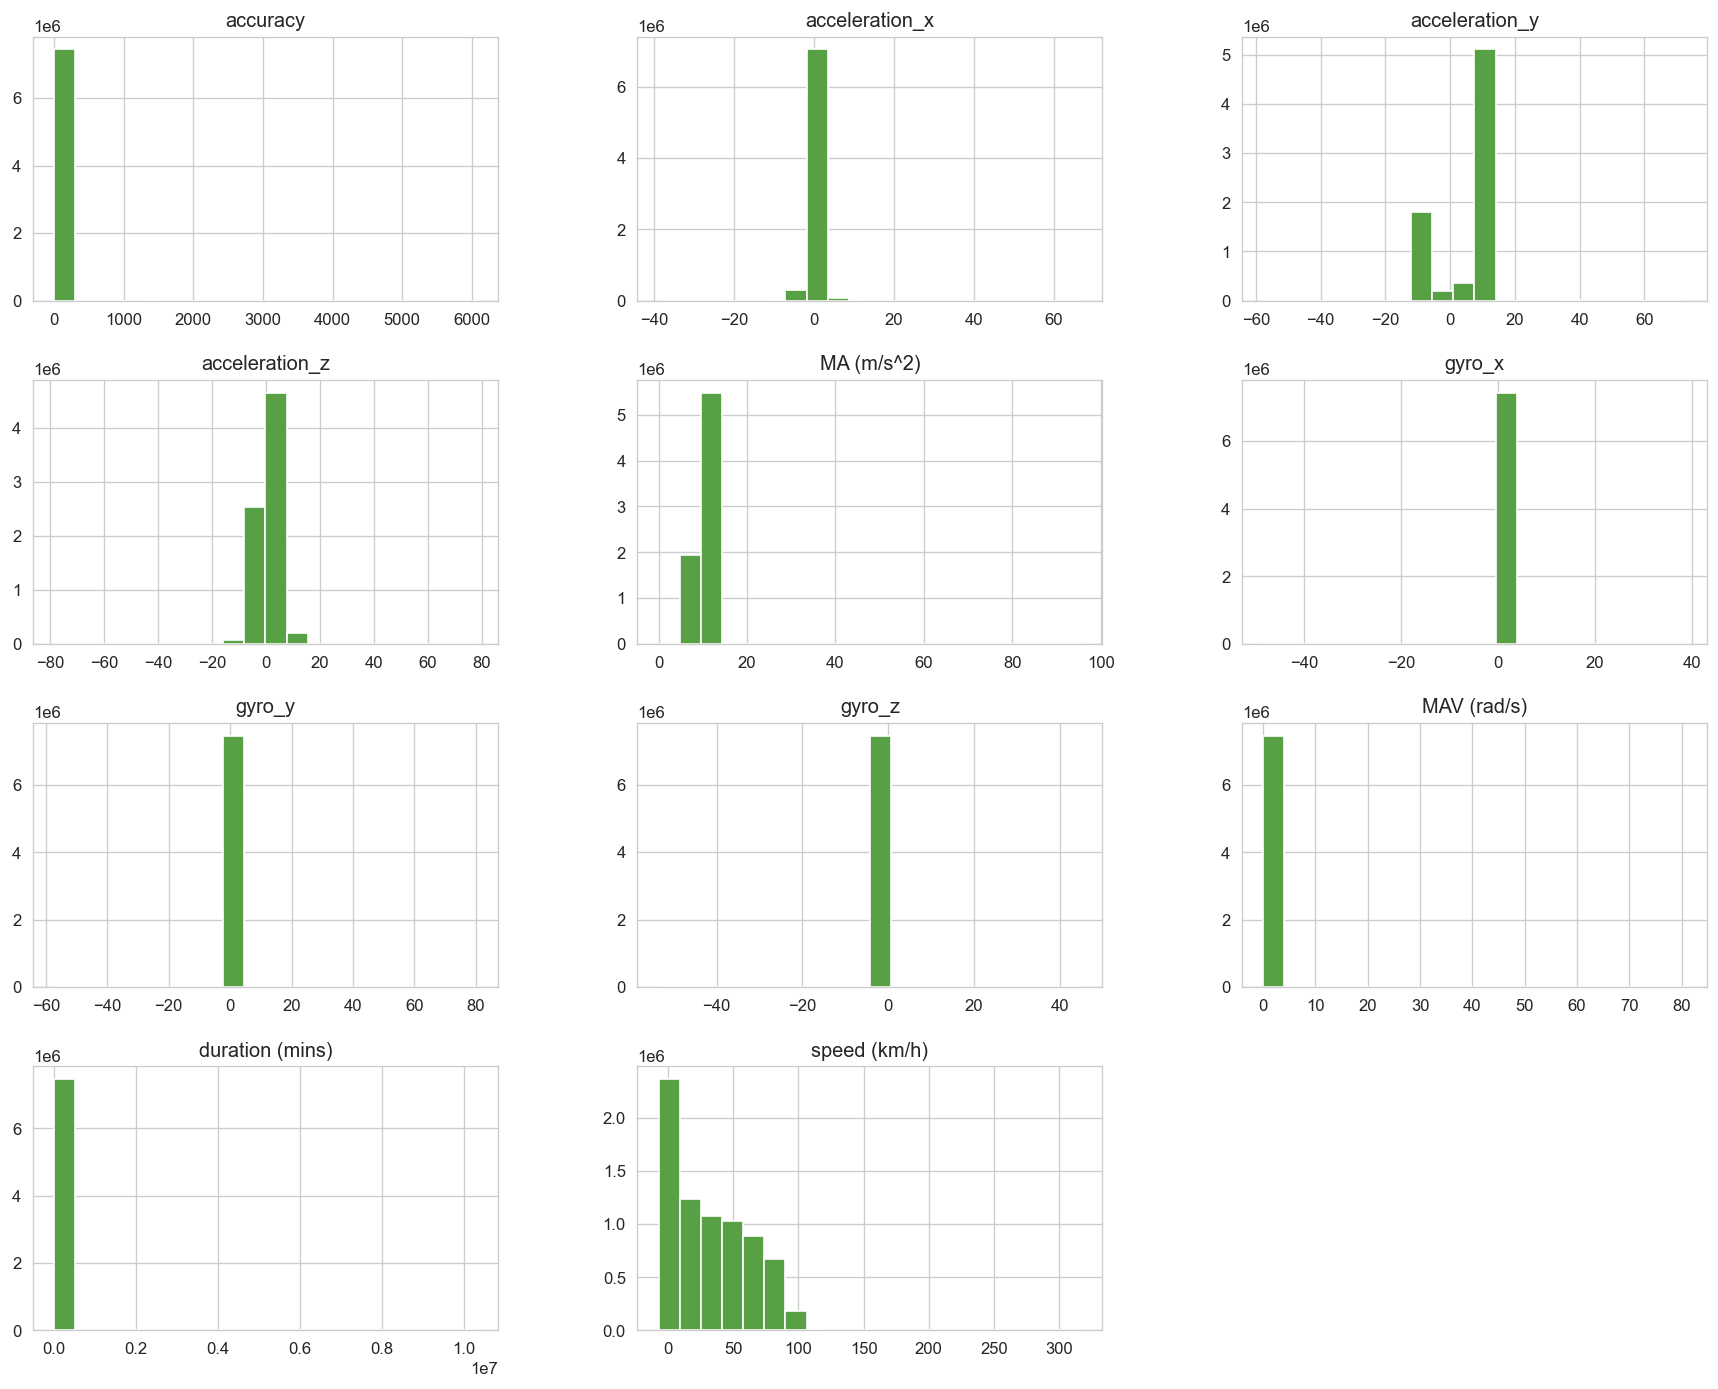

In [62]:
# exclude driver_age, car_make_year, rating, second, speed
cols = ['accuracy', 'acceleration_x', 'acceleration_y', 'acceleration_z',
       'MA (m/s^2)', 'gyro_x', 'gyro_y', 'gyro_z', 'MAV (rad/s)',
       'duration (mins)', 'speed (km/h)']

# plot histograms for numerical columns
cleaned_df[cols].compute().hist(figsize=(18,14), bins=20, color=palette[0])
plt.show()

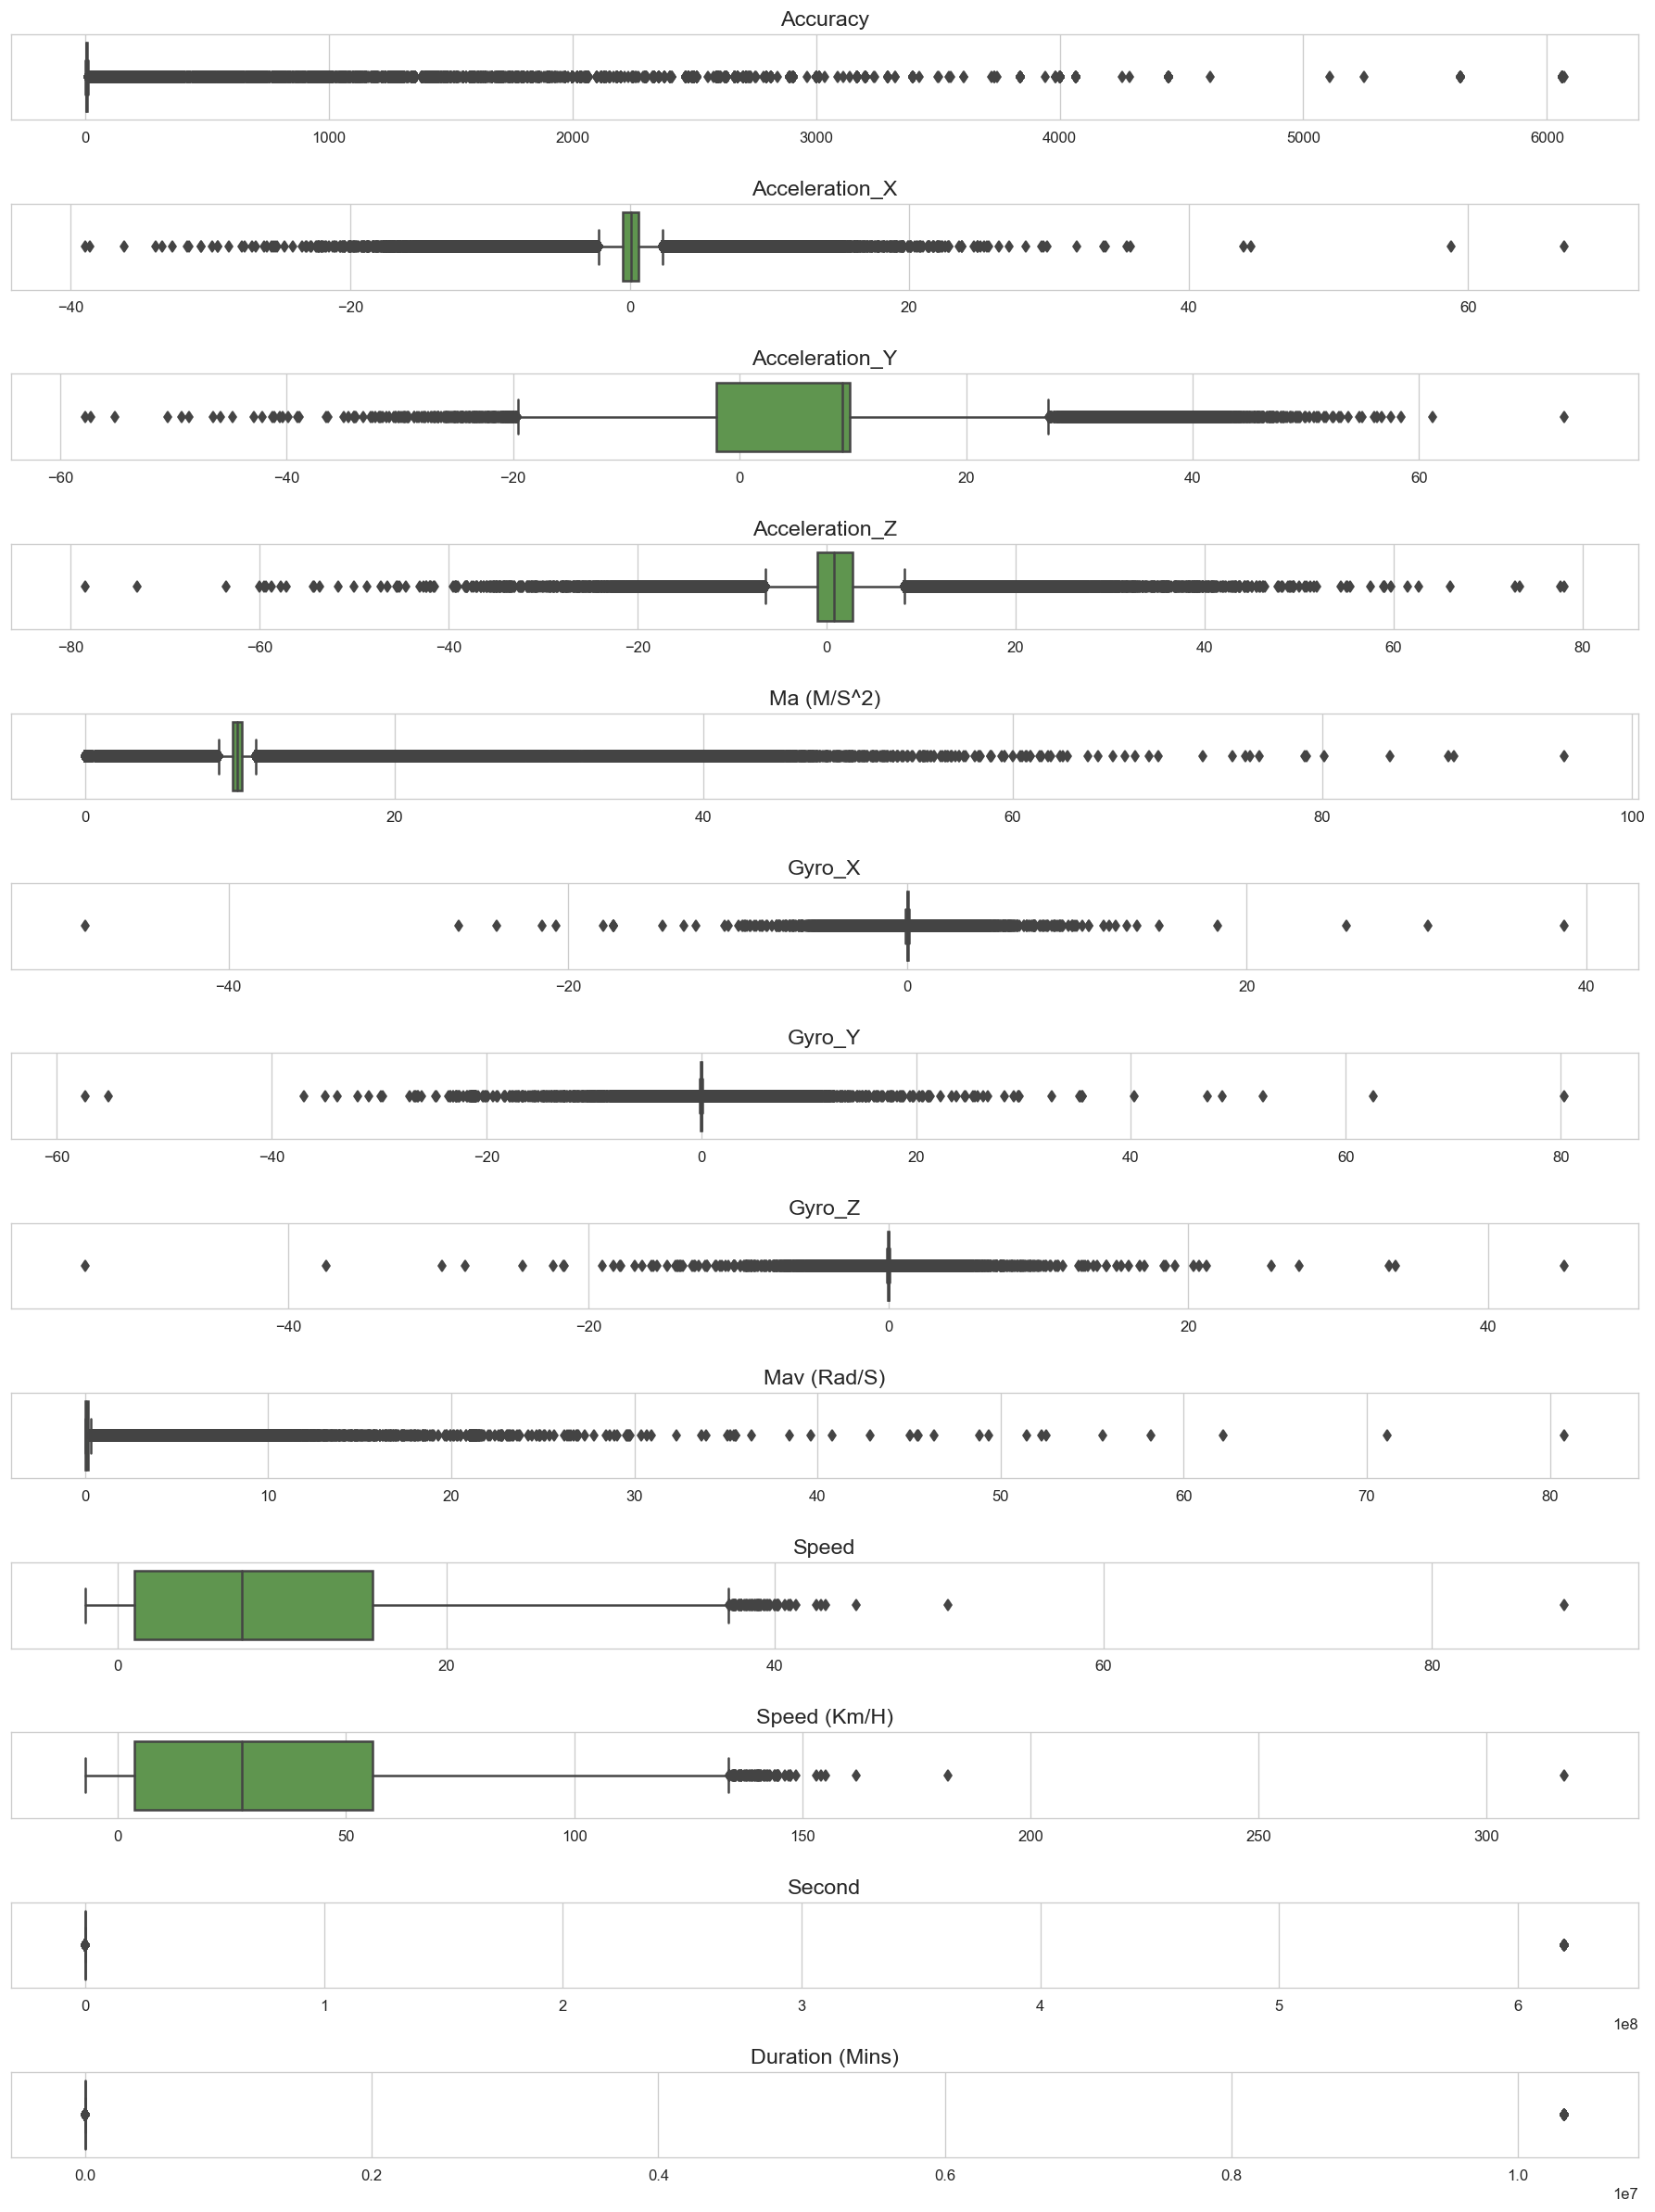

In [63]:
continuous_cols = ['accuracy', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'MA (m/s^2)', 'gyro_x', 'gyro_y', 'gyro_z', 'MAV (rad/s)', 'speed', 'speed (km/h)', 'second', 'duration (mins)'] 

#plot boxplots of each continuous variable
fig, axes = plt.subplots(len(continuous_cols), 1, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(continuous_cols):
    sns.boxplot(x=col, data=cleaned_df.compute(), ax=axes[i], palette=palette)
    axes[i].set_title(f'{col.title()}', fontsize=14, **hfont)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [64]:
# boolean mask to get data where ride time is greater than 720 mins (12 hours)
bool_mask = cleaned_df['duration (mins)'] > 720

# get number of rows in sensor data using boolean mask
print(f"Number of rows in sensor data where ride time > 12 hours: {cleaned_df[bool_mask].compute().shape[0]}")
# get number of unique booking ids using boolean mask
print(f"Number of unique rides where ride time > 12 hours: {cleaned_df[bool_mask].compute()['booking_id'].nunique()}")

# get the percentages of ride time outliers in the dataset
print(f"\nPercentage of sensor data where ride time > 12 hours: {cleaned_df[bool_mask].compute().shape[0] / cleaned_df.compute().shape[0] * 100}%")
print(f"Percentage of unique rides where ride time > 12 hours: {cleaned_df[bool_mask].compute()['booking_id'].nunique() / cleaned_df.compute()['booking_id'].nunique() * 100}%")

Number of rows in sensor data where ride time > 12 hours: 37
Number of unique rides where ride time > 12 hours: 4

Percentage of sensor data where ride time > 12 hours: 0.0004953374024185316%
Percentage of unique rides where ride time > 12 hours: 0.02%


In [65]:
# Counts of sensor logs for each booking id where the ride exceeds 12 hours
cleaned_df[bool_mask].compute()['booking_id'].value_counts()

858993459333     23
1460288880770    11
1434519076976     2
1108101562401     1
Name: booking_id, dtype: int64

In [66]:
# Drop rows where ride time is greater than 720 mins (12 hours) using boolean masking
cleaned_df = cleaned_df[cleaned_df['duration (mins)'] <= 720]
cleaned_df.compute().shape

(7469619, 22)

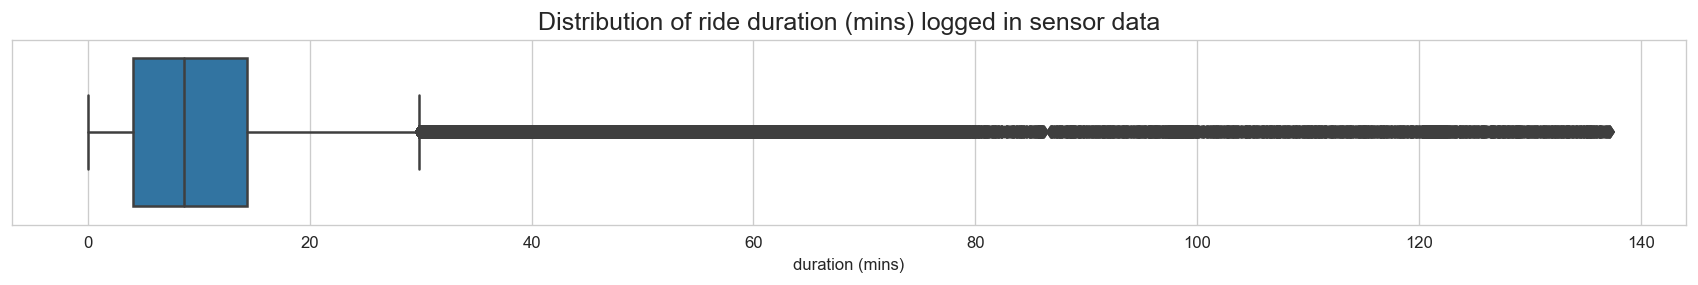

In [67]:
# boxplot of ride time after removing outliers
plt.figure(figsize=(18,2))
sns.boxplot(x=cleaned_df['duration (mins)'].compute())
plt.title(f"Distribution of ride duration (mins) logged in sensor data", fontsize=15)
plt.show()

In [68]:
# boolean mask to get data where rows where G-Force > 2
g_force_bool_mask = cleaned_df['MA (m/s^2)'] / 9.81 > 2

# get number of rows in sensor data where G-Force > 2 using boolean mask
print(f"Number of rows in sensor data where G-Force > 2: {cleaned_df[g_force_bool_mask].compute().shape[0]}")
# get number of unique booking ids where G-Force > 2 using boolean mask
print(f"Number of unique rides where G-Force > 2: {cleaned_df[g_force_bool_mask].compute()['booking_id'].nunique()}")
# get the percentages of G-Force outliers in the dataset
print(f"\nPercentage of sensor data where G-Force > 2: {cleaned_df[g_force_bool_mask].compute().shape[0] / cleaned_df.compute().shape[0] * 100}%")
print(f"Percentage of unique rides where G-Force > 2: {cleaned_df[g_force_bool_mask].compute()['booking_id'].nunique() / cleaned_df.compute()['booking_id'].nunique() * 100}%")

Number of rows in sensor data where G-Force > 2: 10717
Number of unique rides where G-Force > 2: 530

Percentage of sensor data where G-Force > 2: 0.14347451991861968%
Percentage of unique rides where G-Force > 2: 2.65%


In [69]:
# drop rows where G-Force > 2
cleaned_df = cleaned_df[cleaned_df['MA (m/s^2)'] / 9.81 <= 2]
rows, cols = cleaned_df.shape
print(f'Number of rows: {rows.compute()}')  # delayed computation
print(f'Number of columns: {cols}')

Number of rows: 7458902
Number of columns: 22



to check for correlation

bisearial correlation

In [70]:
cleaned_df.isna().sum().compute()

booking_id         0
name               0
driver_age         0
gender             0
car_model          0
car_make_year      0
accuracy           0
direction          0
acceleration_x     0
acceleration_y     0
acceleration_z     0
MA (m/s^2)         0
gyro_x             0
gyro_y             0
gyro_z             0
MAV (rad/s)        0
second             0
duration (mins)    0
speed (km/h)       0
speed              0
rating             0
safety_label       0
dtype: int64

## Statistical Tests

In [71]:
# point biserial correlation between safety label and numerical columns
numerical_cols = ['accuracy', 'acceleration_x', 'acceleration_y', 'acceleration_z', 'MA (m/s^2)', 'gyro_x', 'gyro_y', 'gyro_z', 'MAV (rad/s)', 'speed (km/h)', 'second']

for col in numerical_cols:
    print(f"Point biserial correlation between safety label and {col}: {stats.pointbiserialr(cleaned_df['safety_label'].compute(), cleaned_df[col].compute())[0]}")

Point biserial correlation between safety label and accuracy: 0.009036537816338884
Point biserial correlation between safety label and acceleration_x: 0.0005772749126389511
Point biserial correlation between safety label and acceleration_y: -0.009829775982207235
Point biserial correlation between safety label and acceleration_z: 0.012968973822092299
Point biserial correlation between safety label and MA (m/s^2): 0.016794333002447752
Point biserial correlation between safety label and gyro_x: 0.00335254918499734
Point biserial correlation between safety label and gyro_y: -0.0013337290991148152
Point biserial correlation between safety label and gyro_z: 0.0007900314946374729
Point biserial correlation between safety label and MAV (rad/s): 0.047661915063231135
Point biserial correlation between safety label and speed (km/h): -0.03286814743804845
Point biserial correlation between safety label and second: 0.21184241615589283


In [72]:
# chi2 test for correlation between nominal and nominal variable
nom_features = ['car_model', 'direction']
# chi2 get the p-value
for feature in nom_features:
    print(f"Chi2 Test of Independence with {feature} p-value: {chi2(cleaned_df[['safety_label']], cleaned_df[feature])[1]}")

Chi2 Test of Independence with car_model p-value: [0.]
Chi2 Test of Independence with direction p-value: [0.]


---

## Univariate Analysis

### Categorical Variables

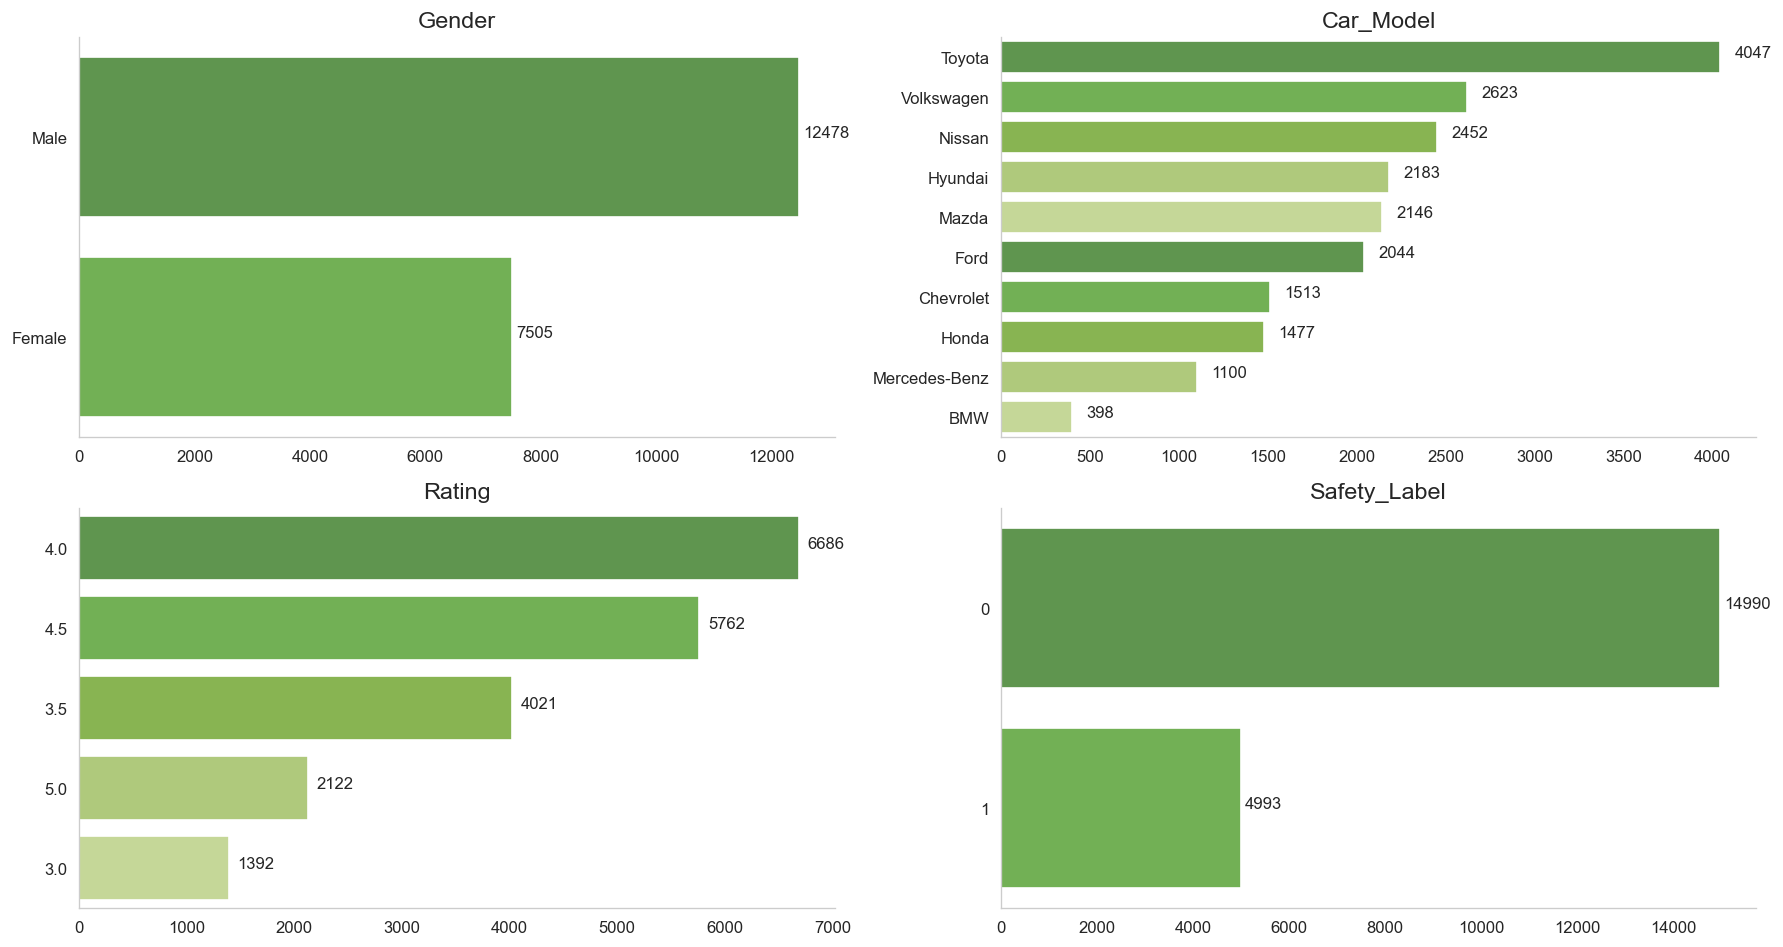

In [73]:
univariate_df = cleaned_df.groupby('booking_id').first().compute()
cat_cols = ['gender', 'car_model', 'rating', 'safety_label']

# plot countplots of each categorical vairable from dask dataframe
fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(y=col, data=univariate_df, ax=axes[i], palette=palette, order=univariate_df[col].value_counts().index)
    axes[i].set_title(f'{col.title()}', fontsize=14, **hfont)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

    # remove scientific notation on x-axis
    axes[i].get_xaxis().get_major_formatter().set_scientific(False)

    # label bars with counts
    for p in axes[i].patches:
        axes[i].annotate(f'{p.get_width():.0f}', (p.get_width() + 80, p.get_y() + 0.4), fontsize=10, **hfont)

    # remove spines and gridlines
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].grid(False)

plt.tight_layout()
plt.show()

### Numerical Variables

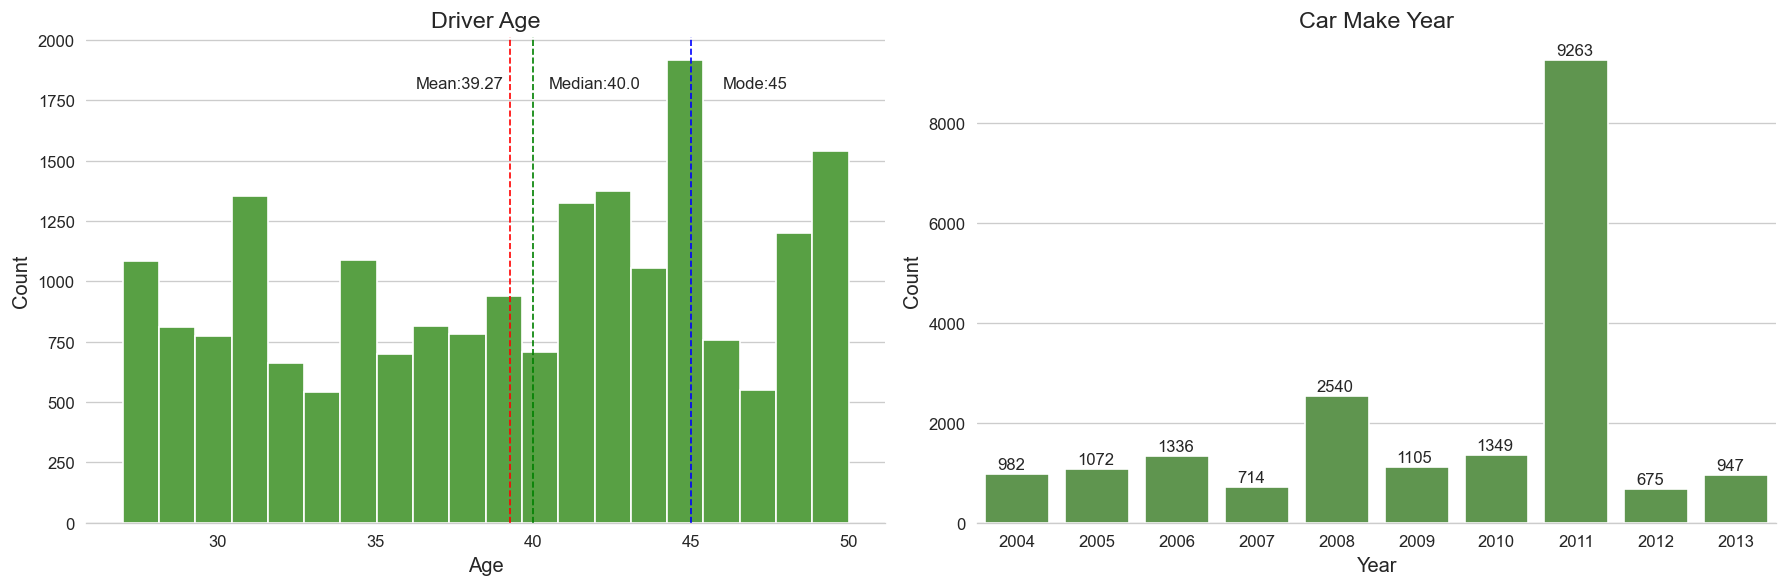

In [74]:
numerical_cols = ['driver_age', 'car_make_year']

#sub plot histograms of driver age and count of car make year
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(univariate_df['driver_age'], bins=20, color=palette[0])
axes[0].set_title('Driver Age', fontsize=14, **hfont)
axes[0].set_xlabel('Age', fontsize=12, **hfont)
axes[0].set_ylabel('Count', fontsize=12, **hfont)

# highlight mean, median and mode
axes[0].axvline(univariate_df['driver_age'].mean(), color='red', linestyle='dashed', linewidth=1)
axes[0].axvline(univariate_df['driver_age'].median(), color='green', linestyle='dashed', linewidth=1)
axes[0].axvline(univariate_df['driver_age'].mode()[0], color='blue', linestyle='dashed', linewidth=1)

# annotate mean, median and mode
axes[0].annotate(f'Mean:{round(univariate_df["driver_age"].mean(), 2)}', (univariate_df["driver_age"].mean() - 3, 1800), fontsize=10, **hfont)
axes[0].annotate(f'Median:{round(univariate_df["driver_age"].median(), 2)}', (univariate_df["driver_age"].median() + 0.5, 1800), fontsize=10, **hfont)
axes[0].annotate(f'Mode:{round(univariate_df["driver_age"].mode()[0], 2)}', (univariate_df["driver_age"].mode()[0] + 1, 1800), fontsize=10, **hfont)

# despine
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].grid(axis='x')

sns.countplot(x='car_make_year', data=univariate_df, color=palette[0], ax=axes[1])
axes[1].set_title('Car Make Year', fontsize=14, **hfont)
axes[1].set_xlabel('Year', fontsize=12, **hfont)
axes[1].set_ylabel('Count', fontsize=12, **hfont)

# despine
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].spines['left'].set_visible(False)

# label bars with counts with padding
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.0f}', (p.get_x() + 0.15, p.get_height() + 100), fontsize=10, **hfont)


plt.tight_layout()
plt.show()

## Correlation

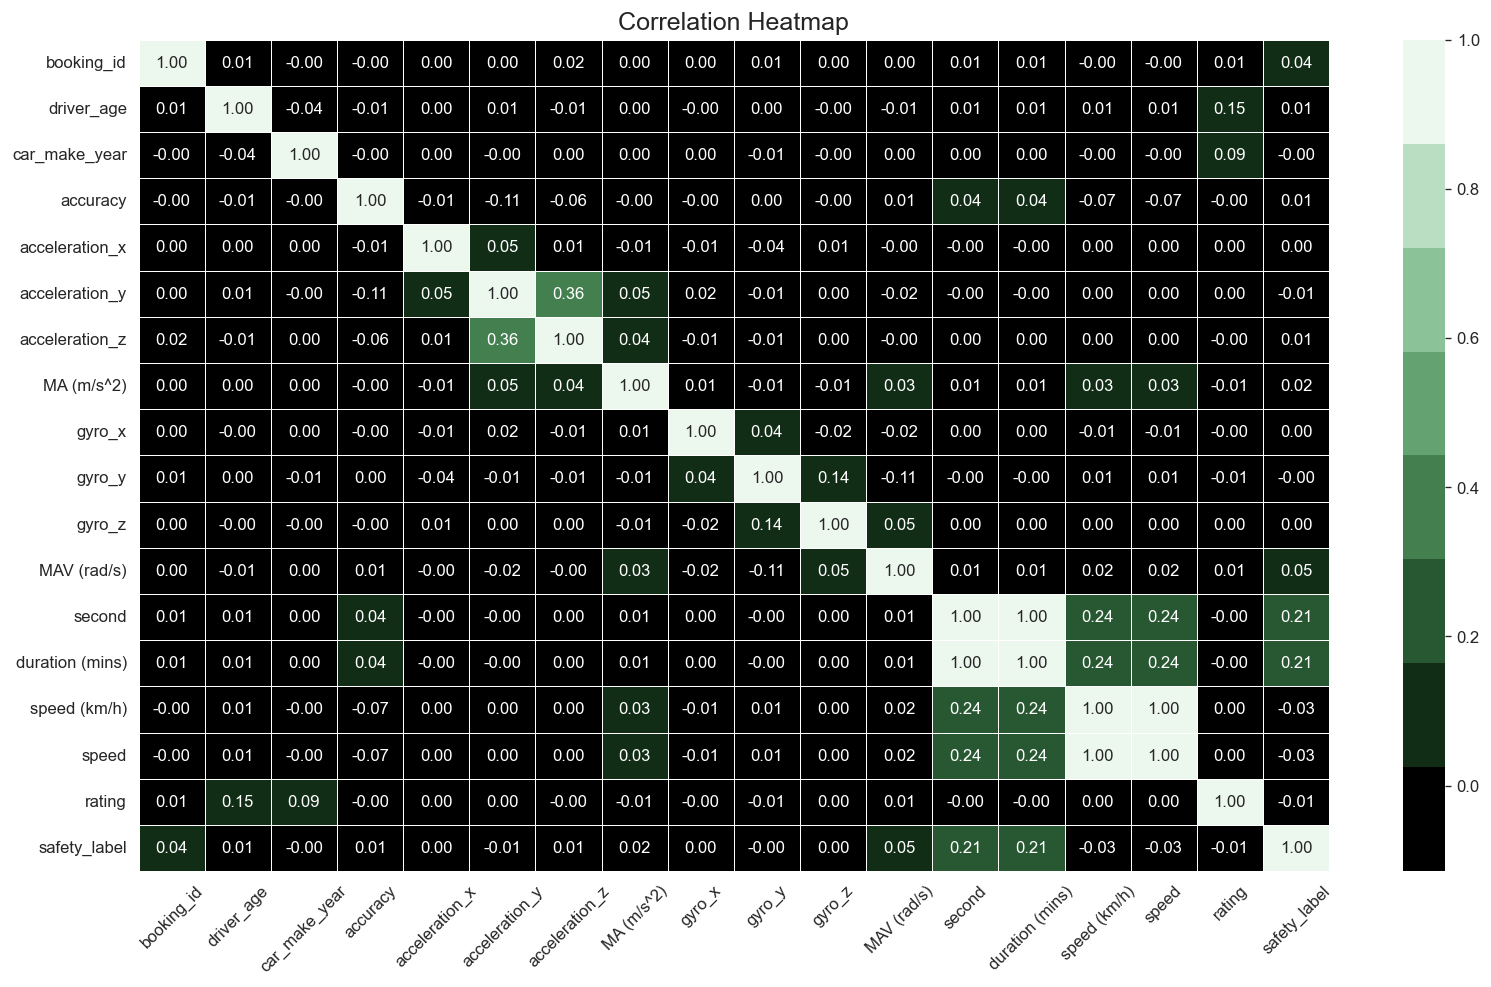

In [75]:
plt.figure(figsize=(16, 9))

sns.heatmap(cleaned_df.corr().compute(), annot=True, cmap=sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True), fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=15)
plt.xticks(rotation=45, **hfont)

plt.show()

---
## Visualization time!!!!!!!!!

In [76]:
plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

In [77]:
%%time
file_path = '../data/cleaned/cleaned_taxi_data.csv'
taxi_df = dd.read_csv(file_path)
taxi_df = taxi_df.persist()
taxi_df.head()

CPU times: total: 30.9 s
Wall time: 7.75 s


,booking_id,name,driver_age,gender,car_model,car_make_year,accuracy,direction,acceleration_x,acceleration_y,...,gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),speed,rating,safety_label
0,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-1.706,-9.271,...,-0.029,-0.033,0.015,0.046,2.000,0.030,0.822,0.228,4.000,0
1,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-1.417,-9.548,...,-0.022,0.005,-0.026,0.035,3.000,0.050,0.822,0.228,4.000,0
2,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-0.347,-9.533,...,0.015,-0.050,0.025,0.058,9.000,0.150,0.822,0.228,4.000,0
3,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-0.601,-9.452,...,0.005,-0.012,-0.004,0.013,11.000,0.180,0.822,0.228,4.000,0
4,0,Lilia,48,Male,Mercedes-Benz,2013,8.000,South East,-0.598,-9.863,...,-0.000,0.000,-0.010,0.010,12.000,0.200,0.822,0.228,4.000,0


In [78]:
# set font family
hfont = {'fontname':'Gill Sans MT'}

## Ride Safety Ratios

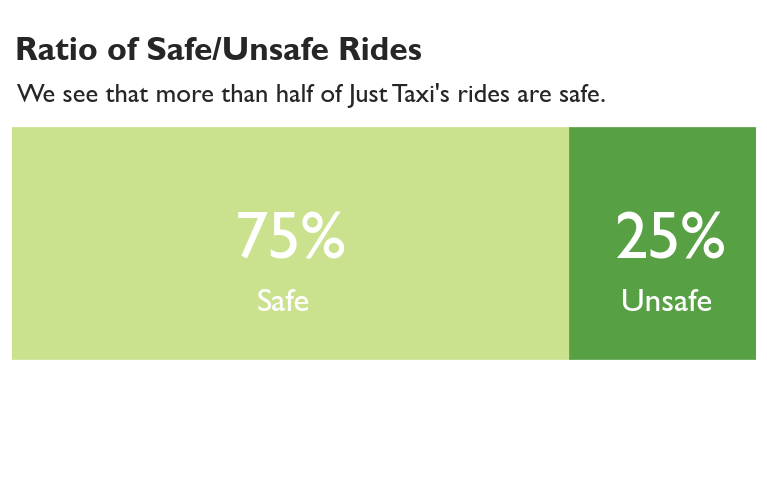

In [79]:
safety_labels = taxi_df.groupby('booking_id').first()['safety_label']
safety_ratios = (safety_labels.compute().value_counts() / len(safety_labels)).round(2)
safety_ratios.index = ['Safe', 'Unsafe']
safety_ratios = safety_ratios.to_frame().T

# ratio plot of safety label
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

axes.barh(safety_ratios.index, safety_ratios['Safe'], color=palette[-1], height=0.5, label='Safe', edgecolor=palette[-1])
axes.barh(safety_ratios.index, safety_ratios['Unsafe'], left=safety_ratios['Safe'], color=palette[0], height=0.5, label='Unsafe', edgecolor=palette[0])

# set y-axis limits
axes.set_ylim(-0.5, 0.5)
axes.set_ylabel('')
axes.set_yticklabels([])

axes.set_xlim(0, 1)
axes.set_xticklabels([])


# safety percentage labels
for i, v in enumerate(safety_ratios['Safe']):
    axes.text(v / 2, i, str(int(v * 100)) + '%', color='white', ha='center', va='center', fontsize=40, **hfont)
    axes.text(v / 2 - 0.01, i - 0.13, 'Safe', color='white', ha='center', va='center', fontsize=20, **hfont)
    

for i, v in enumerate(safety_ratios['Unsafe']):
    axes.text(v / 2 + safety_ratios['Safe'][i] + 0.01, i, str(int(v * 100)) + '%', color='white', ha='center', va='center', fontsize=40, **hfont)
    axes.text(v / 2 + safety_ratios['Safe'][i] + 0.005, i - 0.13, 'Unsafe', color='white', ha='center', va='center', fontsize=20, **hfont)

# set title and annotate
fig.text(0.34, .8, 'Ratio of Safe/Unsafe Rides', fontsize=20, fontweight='bold',  ha='center', **hfont)
fig.text(0.13, 0.73, "We see that more than half of Just Taxi's rides are safe.", fontsize=16, **hfont)  

axes.grid(False)
sns.despine(right=True, top=True, left=True, bottom=True, ax=axes)

plt.show()

## Safe/Unsafe Rides by Car Brands

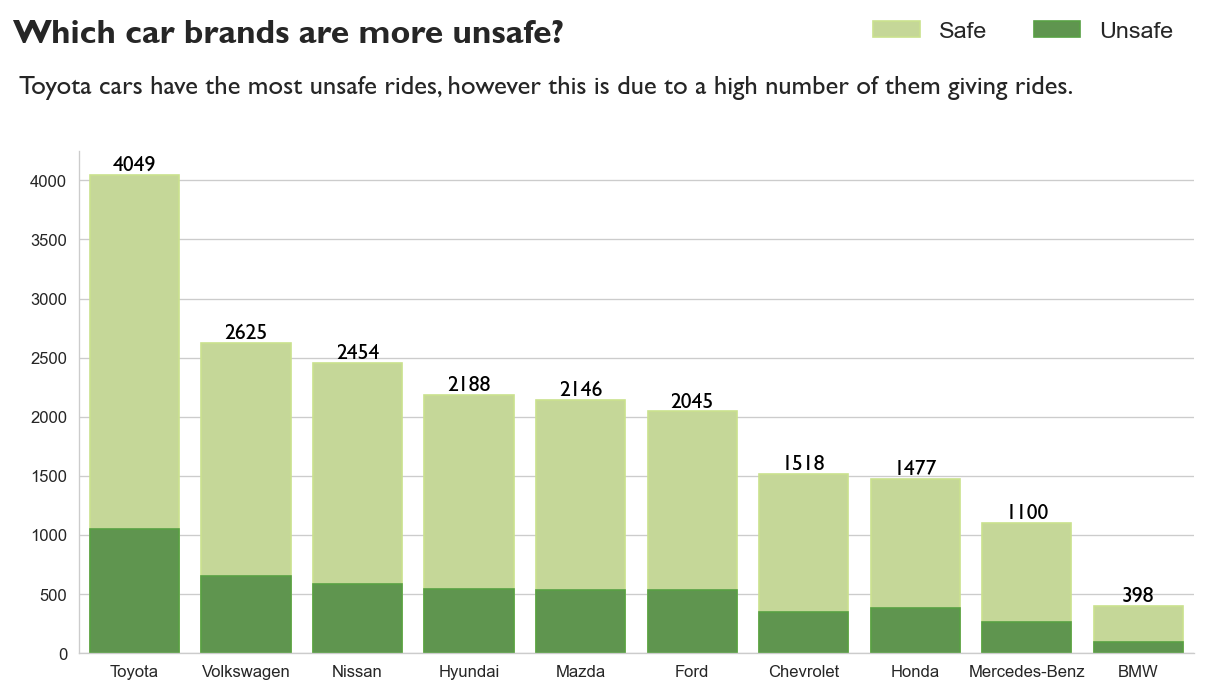

In [80]:
# per booking, what are each car brand's safety ratios?
rides_per_booking = taxi_df.groupby('booking_id').first()

# get number of each car model in dataset
model_counts = rides_per_booking['car_model'].value_counts().compute()

# get number of each car model in safe/unsafe rides
safe_model_counts = rides_per_booking[rides_per_booking['safety_label'] == 0]['car_model'].value_counts().compute()
unsafe_model_counts = rides_per_booking[rides_per_booking['safety_label'] == 1]['car_model'].value_counts().compute()

# get safety ratios
safe_model_ratios = (safe_model_counts / model_counts).round(2)
unsafe_model_ratios = (unsafe_model_counts / model_counts).round(2)

# get safety ratios in dask dataframe
safe_model_ratios = dd.from_pandas(safe_model_ratios, npartitions=1)
unsafe_model_ratios = dd.from_pandas(unsafe_model_ratios, npartitions=1)

# store both safety ratios in one dask dataframe
model_safety_ratios = dd.concat([safe_model_ratios, unsafe_model_ratios], axis=1)
model_safety_ratios.columns = ['safe', 'unsafe']

# store model counts in dask dataframe
model_counts = dd.from_pandas(model_counts, npartitions=1)
# join model counts and safety ratios and rename column to 'count'
model_safety_ratios = model_safety_ratios.join(model_counts, how='inner').rename(columns={'car_model': 'count'})

sorted_model_df = model_safety_ratios.compute().sort_values('count', ascending=False)

colors = [palette[-1] for _ in range(len(sorted_model_df))]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.barplot(x=list(sorted_model_df.index), y=sorted_model_df['count'], palette=colors, edgecolor=colors, ax=axes, label='Safe')
sns.barplot(x=list(sorted_model_df.index), y=sorted_model_df['unsafe'] * sorted_model_df['count'], color=palette[0], edgecolor=palette[0], ax=axes, label='Unsafe')

# label tiotal number of rides per car model
for i, v in enumerate(sorted_model_df['count']):
    axes.text(i, v + 80, str(v), color='black', ha='center', va='center', fontsize=13, **hfont)

axes.set_xlabel('')
axes.set_ylabel('')

# set title and annotate
fig.text(0.23, 0.91, 'Which car brands are more unsafe?', fontsize=20, fontweight='bold',  ha='center', **hfont)
fig.text(0.006, 0.84, "Toyota cars have the most unsafe rides, however this is due to a high number of them giving rides.", fontsize=16, **hfont)  

axes.legend(loc='upper right', fontsize=14, frameon=False, ncol=2, bbox_to_anchor=(1, 1.3))
sns.despine(right=True, top=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

## Proportion of Unsafes Rides

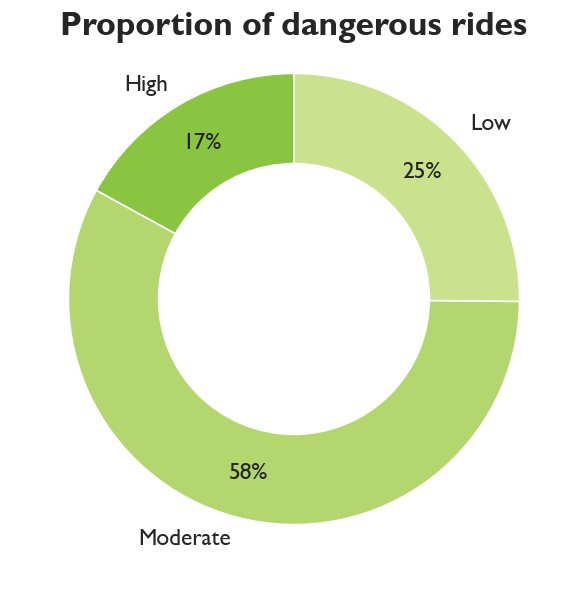

In [81]:
driver_safety_ratio = taxi_df.groupby('booking_id').first()
driver_safety_ratio = driver_safety_ratio.groupby('name')['safety_label'].value_counts().compute()
driver_safety_ratio = driver_safety_ratio.to_frame().unstack()  # convert to df and unstack
driver_safety_ratio.columns = driver_safety_ratio.columns.droplevel(0)  # remove multiindex
driver_safety_ratio.columns = ['safe', 'unsafe']  # rename columns
driver_safety_ratio['total'] = driver_safety_ratio['safe'] + driver_safety_ratio['unsafe']  # add total column

unsafe_pct = (driver_safety_ratio['unsafe'] / driver_safety_ratio['total']).round(2)
unsafe_pct = unsafe_pct.sort_values(ascending=False)

# group unsafe pct into buckets and store in dask dataframe
unsafe_df = dd.from_pandas(unsafe_pct, npartitions=1)
unsafe_df = unsafe_df.to_frame().reset_index()
unsafe_df.columns = ['name', 'unsafe_pct']
unsafe_df['group'] = unsafe_df['unsafe_pct'].apply(
    lambda x: 
        'High' if x >= 0.29 else 
        ('Moderate' if x >= 0.23
        else 'Low'), 
        meta=('group', 'object')
)
unsafe_df = unsafe_df.set_index('name')

unsafety_groups = unsafe_df['group'].value_counts()
unsafety_groups = unsafety_groups.to_frame()
# reorder groups
unsafety_groups = unsafety_groups.compute().reindex(['High', 'Moderate', 'Low'])

# donut chart of unsafe groups
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# plot donut chart
axes.pie(unsafety_groups['group'], labels=unsafety_groups.index, colors=palette[-3:], autopct='%1.0f%%', startangle=90, pctdistance=0.80, textprops={'fontsize': 14, **hfont})
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# set title and annotate
fig.text(0.5, 0.94, 'Proportion of dangerous rides', fontsize=20, fontweight='bold',  ha='center', **hfont)
# fig.text(0.2, 0.85, "Most drivers have a moderate amount of unsafe rides within the dataset.", fontsize=14, **hfont)

sns.despine(right=True, top=True, left=True, bottom=True)
plt.tight_layout()
plt.show()

## Most Dangerous Drivers

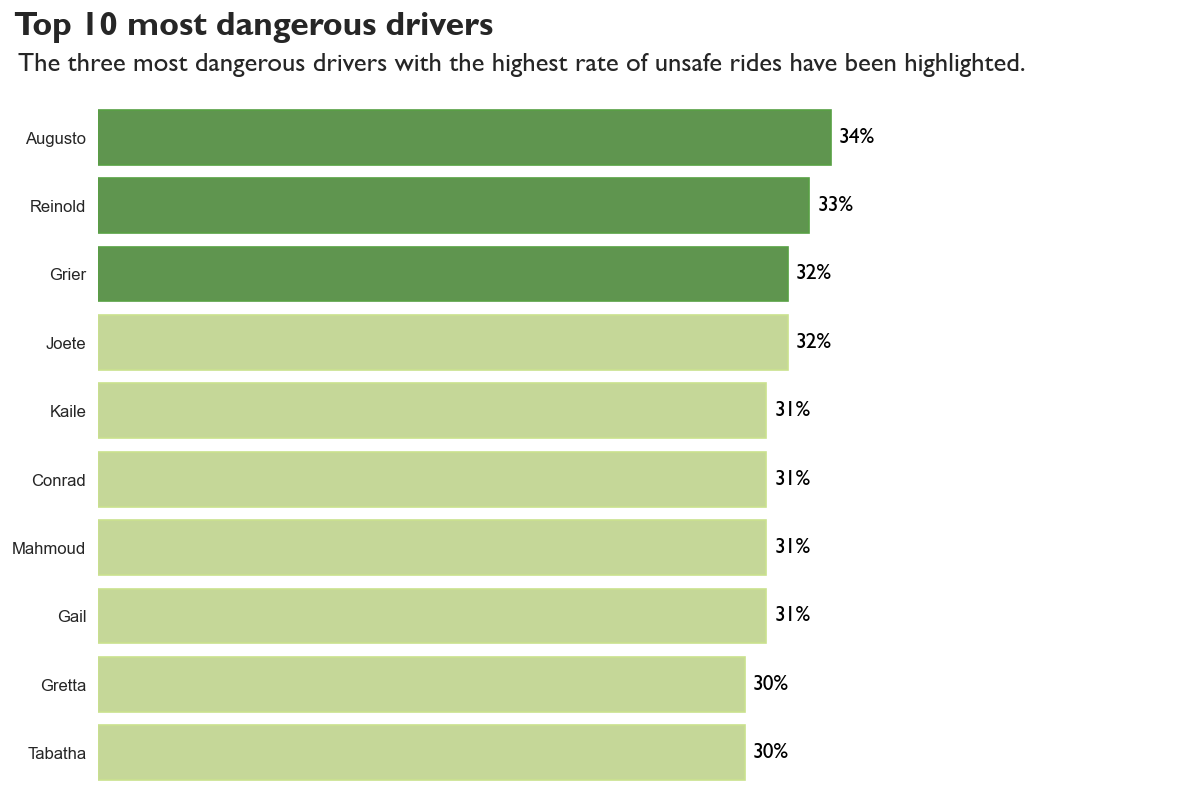

In [82]:
driver_safety_ratio['danger_rate'] = (driver_safety_ratio['unsafe'] / driver_safety_ratio['total']).round(2)

# top 10 drivers with highest number/percentage of unsafe rides
top_10_unsafe_drivers = driver_safety_ratio.sort_values('danger_rate', ascending=False).head(10)

colours = [palette[-1] for _ in range(len(top_10_unsafe_drivers))]
colors[0] = colors[1] = colors[2] = palette[0]

# plot barh chart
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.barplot(x=top_10_unsafe_drivers['danger_rate'], y=top_10_unsafe_drivers.index, palette=colors, edgecolor=colors, ax=axes)

# label percentage of unsafe rides
for i, v in enumerate(top_10_unsafe_drivers['danger_rate']):
    axes.text(v + 0.012, i, f'{int(v * 100)}%', color='black', ha='center', va='center', fontsize=13, **hfont)

axes.set_xlabel('')
axes.set_xticks([])
axes.set_ylabel('')
axes.set_xlim(0, 0.5)
axes.grid(False)

# set title and annotate
fig.text(0.216, 1.07, 'Top 10 most dangerous drivers', fontsize=20, fontweight='bold',  ha='center', **hfont)
fig.text(0.02, 1.02, "The three most dangerous drivers with the highest rate of unsafe rides have been highlighted. ", fontsize=16, **hfont)


sns.despine(right=True, top=True, left=True, bottom=True)
plt.tight_layout()
plt.show()

## Unsafe rides by age groups

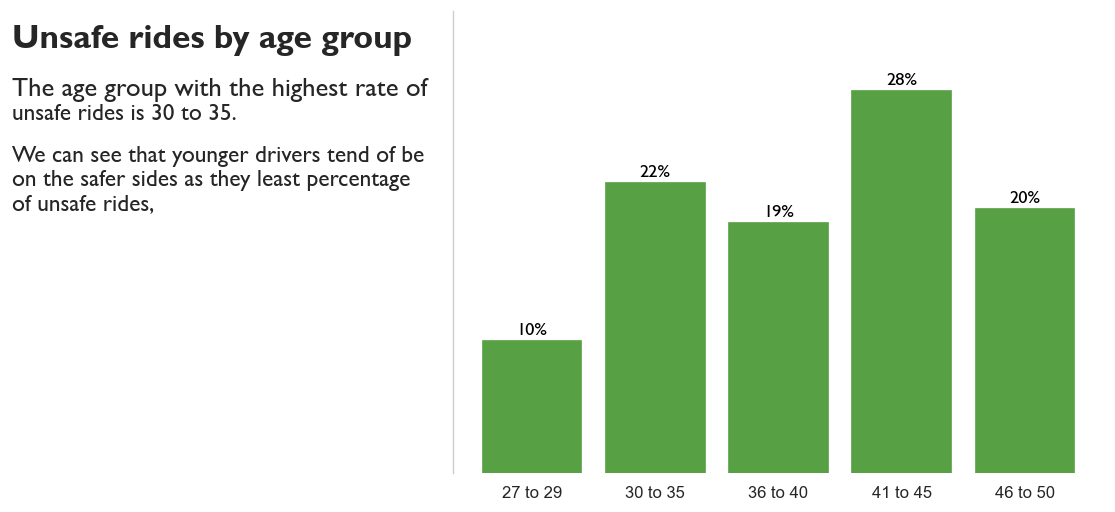

In [94]:
age_by_safety = taxi_df.groupby('booking_id')[['driver_age', 'safety_label']].first()

age_by_safety = age_by_safety.groupby('driver_age')['safety_label'].value_counts()
age_by_safety = age_by_safety.to_frame().compute().unstack()
age_by_safety.columns = age_by_safety.columns.droplevel(0)
age_by_safety.columns = ['safe', 'unsafe']
age_by_safety['total'] = age_by_safety['safe'] + age_by_safety['unsafe']
age_by_safety['safe_pct'] = (age_by_safety['safe'] / age_by_safety['total']).round(2)
age_by_safety['unsafe_pct'] = (age_by_safety['unsafe'] / age_by_safety['total']).round(2)
age_by_safety.reset_index(inplace=True)

# age groups: 
# 27 to 29, 
# 30 to 35, 
# 36 to 40
# 41 to 45
# 46 to 50
age_by_safety['age_group'] = age_by_safety['driver_age'].apply(
    lambda x:
        '27 to 29' if x >= 27 and x <= 29 else
        ('30 to 35' if x >= 30 and x <= 35 else
        ('36 to 40' if x >= 36 and x <= 40 else
        ('41 to 45' if x >= 41 and x <= 45 else
        ('46 to 50'))))
)

age_by_safety = age_by_safety.groupby('age_group')[['safe','unsafe']].sum()
age_by_safety['safe_pct'] = (age_by_safety['safe'] / age_by_safety['safe'].sum()).round(2)
age_by_safety['unsafe_pct'] = (age_by_safety['unsafe'] / age_by_safety['unsafe'].sum()).round(2)

# remove safe only plot unsafe
unsafe_pct = age_by_safety['unsafe_pct']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.bar(unsafe_pct.index, unsafe_pct, width=.8, color=palette[0], edgecolor=palette[0])

# annote unsafe and convert values toto positive
for i, v in enumerate(unsafe_pct):
    axes.text(i, v + 0.008, f'{int(v * 100)}%', color='black', ha='center', va='center', fontweight='light', fontsize=11, **hfont)

axes.set_yticks([])
axes.set_ylim(0, 0.35)

# set title and annotate
fig.text(-0.4, 0.82, 'Unsafe rides by age group', fontsize=20, fontweight='bold',  ha='left', **hfont)
fig.text(-0.4, 0.74, "The age group with the highest rate of", fontsize=16, ha='left', **hfont)
fig.text(-0.4, 0.70, "unsafe rides is 30 to 35.", fontsize=14, ha='left', **hfont)

fig.text(-0.4, 0.55, "We can see that younger drivers tend of be\non the safer sides as they least percentage\nof unsafe rides, ", fontsize=14, ha='left', **hfont)

axes.grid(False)
sns.despine(right=True, top=True, left=False, bottom=True)
plt.show()

## Violin plot of speed by safety label

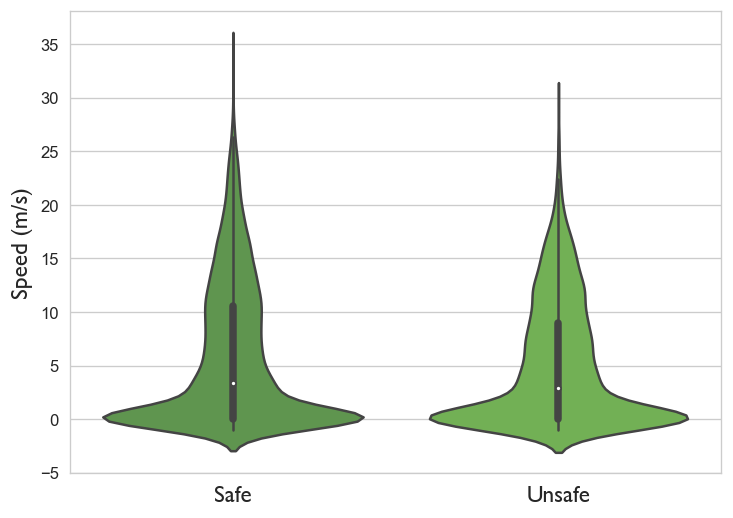

In [95]:
test = taxi_df.groupby('booking_id').first()[['speed', 'safety_label']]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

sns.violinplot(x='safety_label', y='speed', data=test.compute(), palette=palette, ax=axes)

axes.set_xlabel('')
axes.set_ylabel('Speed (m/s)', fontsize=14, **hfont)
axes.set_xticklabels(['Safe', 'Unsafe'], fontsize=14, **hfont)
# axes.set_yticks([0, 20, 40, 60, 80, 100])
# axes.set_ylim(0, 200)

plt.show()

## Pairplot of acceleration and gyro values by safety labels

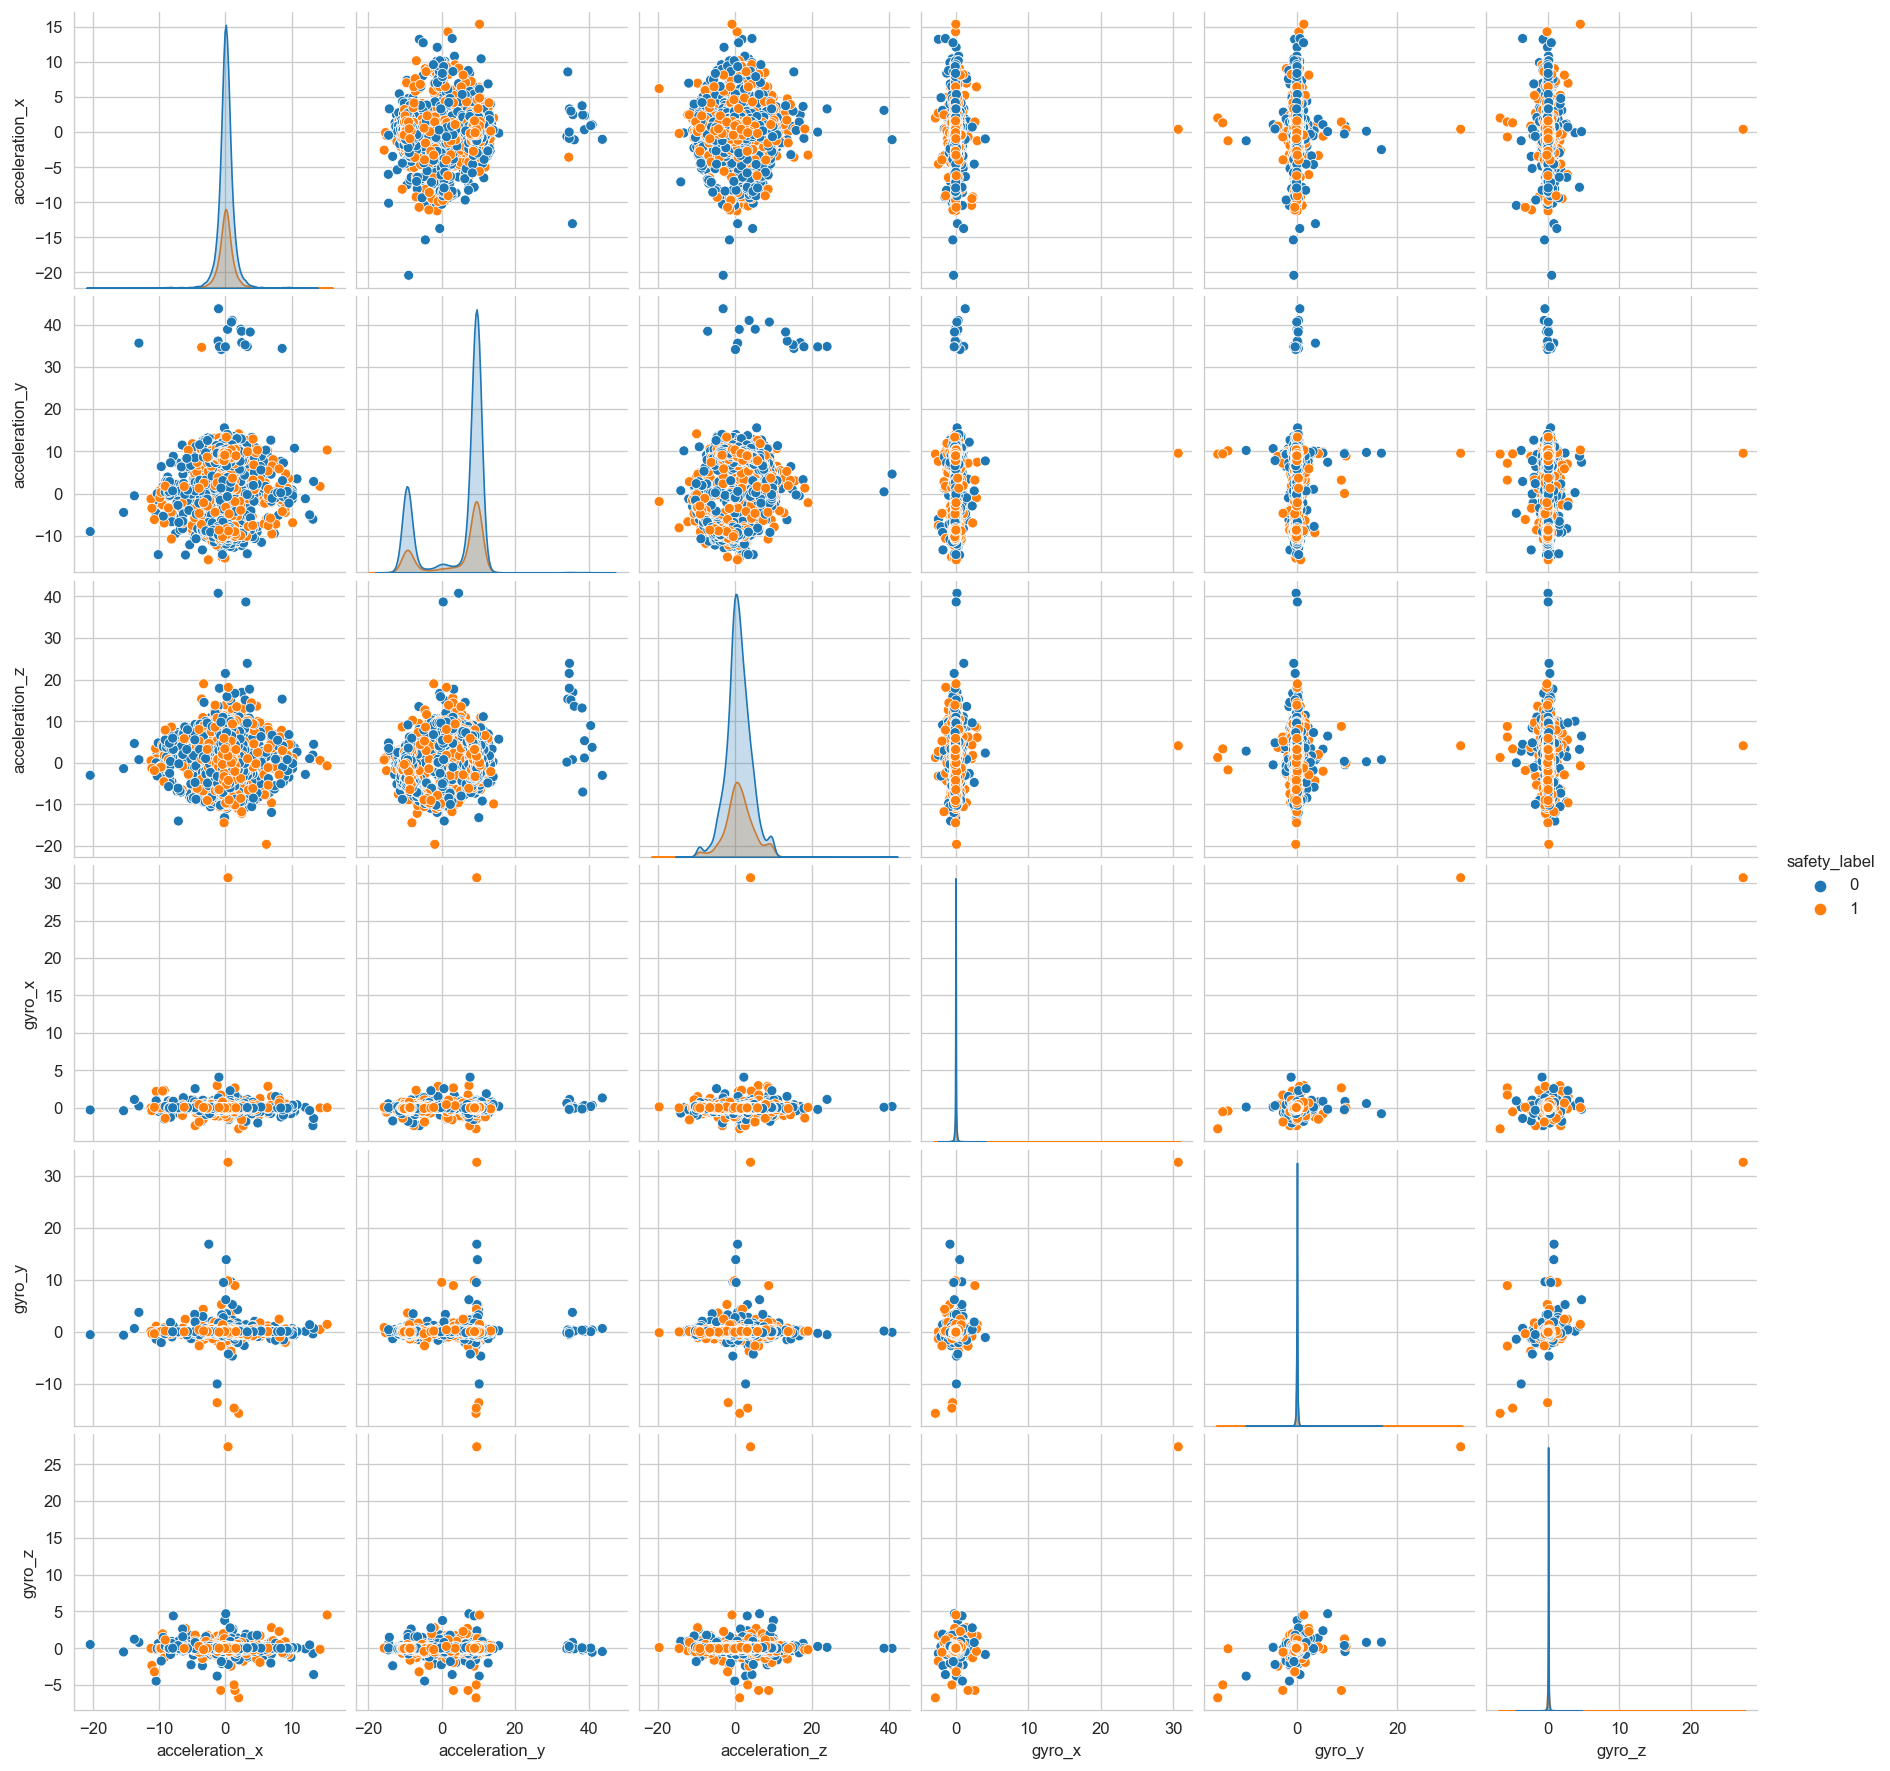

In [85]:
test = taxi_df.groupby('booking_id').first()
subset = test[['acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'safety_label']]
sns.pairplot(subset.compute(), hue='safety_label')
plt.show()